# <span style="color:#1f77b4">**Machine Learning 04 - Deep Learning**</span>


### <span style="color:#1f77b4">**Unity Catalog configuration**</span>

Set up widgets for `CATALOG`, `SCHEMA`, and `VOLUME`, resolve the active catalog, and build the `BASE` path.


In [0]:
# Configure Unity Catalog widgets and resolve the active catalog.

# Unity Catalog config for this project
dbutils.widgets.removeAll()
dbutils.widgets.text("CATALOG", "")
dbutils.widgets.text("SCHEMA", "default")
dbutils.widgets.text("VOLUME", "ml_lab")

catalog_widget = dbutils.widgets.get("CATALOG")
if catalog_widget:
    CATALOG = catalog_widget
else:
    # Prefer current catalog, otherwise pick the first non-system catalog
    current = spark.sql("SELECT current_catalog()").first()[0]
    catalogs = [r.catalog for r in spark.sql("SHOW CATALOGS").collect()]
    CATALOG = current if current not in ("system",) else next(c for c in catalogs if c not in ("system",))

SCHEMA = dbutils.widgets.get("SCHEMA")
VOLUME = dbutils.widgets.get("VOLUME")
BASE = f"dbfs:/Volumes/{CATALOG}/{SCHEMA}/{VOLUME}"


### <span style="color:#1f77b4">**Create schema and volume**</span>

Ensure the Unity Catalog schema and volume exist before storing artifacts.


In [0]:
# Create the schema and volume if needed.

# Ensure schema and volume exist
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {CATALOG}.{SCHEMA}")
spark.sql(f"CREATE VOLUME IF NOT EXISTS {CATALOG}.{SCHEMA}.{VOLUME}")


DataFrame[]

### <span style="color:#1f77b4">**Load data into the UC volume**</span>

Copy the diabetes CSV into the Unity Catalog volume only if it is missing.


In [0]:
# Sync raw data files into the UC volume (only if missing)
data_dir = f"{BASE}/diabetes"
data_file = f"{data_dir}/diabetes.csv"
try:
    dbutils.fs.ls(data_file)
    file_exists = True
except Exception:
    file_exists = False

if not file_exists:
    dbutils.fs.mkdirs(data_dir)
    dbutils.fs.cp("https://raw.githubusercontent.com/Ch3rry-Pi3-Azure/DataBricks-Machine-Learning/refs/heads/main/data/diabetes.csv", data_file)


### <span style="color:#1f77b4">**Prepare data for PyTorch**</span>

Load the CSV, convert to Pandas/NumPy, and split into train/test arrays.


In [0]:
# Convert to NumPy arrays and split for training/testing.

# Import required libraries
from pyspark.sql.types import *
from pyspark.sql.functions import *
from sklearn.model_selection import train_test_split
import numpy as np
   
# Load the data, removing any incomplete rows
df = spark.read.format("csv").option("header", "true").load(BASE + "/diabetes/diabetes.csv").dropna()

# Split the data into training and testing datasets   
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' , 'DiabetesPedigreeFunction' , 'Age' ]
label = 'Outcome'

# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(df.toPandas()[features].values,
                                                    df.toPandas()[label].values,
                                                    test_size=0.30,
                                                    random_state=0)
   
x_train = x_train.astype(np.float32)  # Or np.int64, based on your needs
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int64)

print ('Training Set: %d rows, Test Set: %d rows \n' % (len(x_train), len(x_test)))


Training Set: 537 rows, Test Set: 231 rows 



### <span style="color:#1f77b4">**Import PyTorch modules**</span>

Import core PyTorch modules and set a random seed for reproducibility.


In [0]:
# Import PyTorch modules and set the random seed.

# Import required libraries
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
   
# Set random seed for reproducability
torch.manual_seed(0)
   
print("Libraries imported - ready to use PyTorch", torch.__version__)


Libraries imported - ready to use PyTorch 2.4.0+cpu


### <span style="color:#1f77b4">**Create data loaders**</span>

Wrap NumPy arrays in `TensorDataset` and `DataLoader` for mini?batch training.


In [0]:
# Build DataLoaders for batch processing.

# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
                             shuffle=False, num_workers=1)
print('Ready to load data')


Ready to load data


### <span style="color:#1f77b4">**Define the neural network**</span>

Build a small feed?forward network for diabetes prediction.


In [0]:
# Define the model architecture.

h1 = 10 

# Define the neural network
class DiabetesNet(nn.Module):
 def __init__(self):
    super(DiabetesNet, self).__init__()
    self.fc1 = nn.Linear(len(features), h1) # defining the input layer
    self.fc2 = nn.Linear(h1,h1) # defining the hidden layers
    self.fc3 = nn.Linear(h1,2) # defining the output layer

 def forward(self, x):
    fc1_output = torch.relu(self.fc1(x))
    fc2_output = torch.relu(self.fc2(fc1_output))
    y = F.log_softmax(self.fc3(fc2_output).float(), dim=1)
    return y

# Create a model instance from the network
model = DiabetesNet()
print(model)


DiabetesNet(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


### <span style="color:#1f77b4">**Define training loops**</span>

Create training and evaluation functions to compute loss and accuracy each epoch.


In [0]:
# Implement train/test loops with loss tracking.

def train(model, data_loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # set the model to training mode
    model.train()
    train_loss=0

    for batch,tensor in enumerate(data_loader):
        data, target = tensor
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss = train_loss + loss.item()

        # backpropagate adjustments to the weight
        loss.backward()
        optimizer.step()
    
    # Return the average loss 
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # switch the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
         batch_count = 0
         for batch, tensor in enumerate(data_loader):
             batch_count += 1
             data, target = tensor
             # get the predictions
             out = model(data)

             # calculate the loss
             test_loss = loss_criteria(out, target).item() + test_loss

             # calculate the accuracy
             _, predicted = torch.max(out.data,1)
             correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
       
    # return average loss for the epoch
    return avg_loss


### <span style="color:#1f77b4">**Train the network**</span>

Set loss/optimizer, run epochs, and track training and validation loss.


In [0]:
# Train the model and track loss over epochs.

# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()
   
# Use an optimizer to adjust weights and reduce loss
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
   
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
   
# Train over 100 epochs
epochs = 100
for epoch in range(1, epochs + 1):
   
    # print the epoch number
    print('Epoch: {}'.format(epoch))
       
    # Feed training data into the model
    train_loss = train(model, train_loader, optimizer)
       
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
       
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1
Training set: Average loss: 1.000984
Validation set: Average loss: 0.816932, Accuracy: 144/231 (62%)

Epoch: 2
Training set: Average loss: 0.794878
Validation set: Average loss: 0.685467, Accuracy: 151/231 (65%)

Epoch: 3
Training set: Average loss: 0.710953
Validation set: Average loss: 0.653643, Accuracy: 154/231 (67%)

Epoch: 4
Training set: Average loss: 0.680949
Validation set: Average loss: 0.632639, Accuracy: 156/231 (68%)

Epoch: 5
Training set: Average loss: 0.661040
Validation set: Average loss: 0.617811, Accuracy: 157/231 (68%)

Epoch: 6
Training set: Average loss: 0.646509
Validation set: Average loss: 0.607066, Accuracy: 158/231 (68%)

Epoch: 7
Training set: Average loss: 0.634325
Validation set: Average loss: 0.597923, Accuracy: 161/231 (70%)

Epoch: 8
Training set: Average loss: 0.624252
Validation set: Average loss: 0.591138, Accuracy: 163/231 (71%)

Epoch: 9
Training set: Average loss: 0.616736
Validation set: Average loss: 0.588567, Accuracy: 164/231 (71%)

E

### <span style="color:#1f77b4">**Plot training curves**</span>

Visualize training vs validation loss to check convergence.


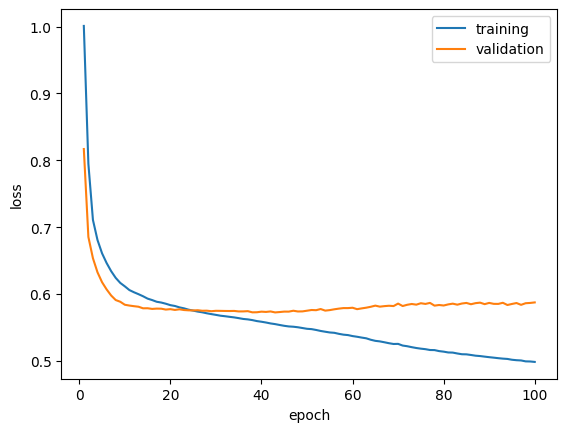

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
   
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


### <span style="color:#1f77b4">**Inspect model weights**</span>

Review learned weights and biases to understand the trained model parameters.


In [0]:
# Print learned parameters for inspection.

for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())


fc1.weight 
 [[-0.09584559  0.15925047 -0.32094464 -0.1517206  -0.20794886  0.07334661
   0.26702428  0.23890038]
 [-0.10095122  0.04456041 -0.11717616 -0.06393753 -0.3377667  -0.4360093
   0.14882414  0.11520825]
 [ 0.2028586   0.17738488 -0.18699366 -0.2372672   0.18302885  0.21917269
  -0.26133537  0.30019113]
 [ 0.32577786  0.01734847  0.36249933 -0.17223072 -0.32949966 -0.03236897
  -0.01071629  0.37769735]
 [-0.2291661  -0.16275224 -0.2470067  -0.3311243  -0.20638342  0.3039138
   0.15776202  0.17135762]
 [ 0.01859392 -0.19853184  0.04254508 -0.33011094 -0.25546575 -0.1995381
   0.20580192  0.19002499]
 [-0.29838887 -0.04612286  0.2867254   0.2199426   0.17531924  0.06544981
  -0.35391006 -0.34138775]
 [ 0.00436369 -0.23727287 -0.14867583  0.02207575  0.17979524  0.33609146
   0.00971928  0.23619227]
 [ 0.12236202  0.02816569 -0.08185973  0.17259684  0.17059138  0.37277117
   0.1234006  -0.11285542]
 [-0.20382749  0.22540936  0.28071207  0.3860218   0.09116191 -0.20527221
   0.27

### <span style="color:#1f77b4">**Save the model**</span>

Save weights locally and copy them into the Unity Catalog volume for persistence.


In [0]:
# Save weights locally and copy to UC storage.

# Save the model weights
import os
local_models_dir = '/local_disk0/diabetes_models'
os.makedirs(local_models_dir, exist_ok=True)
model_file = local_models_dir + '/diabetes_predictor.pt'
torch.save(model.state_dict(), model_file)
# Copy the model into the UC volume for persistence
dbutils.fs.mkdirs(BASE + '/models')
dbutils.fs.cp('file:' + model_file, BASE + '/models/diabetes_predictor.pt', True)
del model
print('model saved as', BASE + '/models/diabetes_predictor.pt')


model saved as dbfs:/Volumes/dbw_databricks_ml_jaguar/default/ml_lab/models/diabetes_predictor.pt


### <span style="color:#1f77b4">**Run inference**</span>

Reload weights and score a new sample to validate the model end?to?end.


In [0]:
# Reload the model and predict a new sample.

# New Diabetes Features
x_new = [[8,85,65,29,0,26.6,0.672,32]]
print ('New sample: {}'.format(x_new))
   
# Create a new model class and load weights
model = DiabetesNet()
model.load_state_dict(torch.load(model_file))
   
# Set model to evaluation mode
model.eval()
   
# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)
   
print('Prediction:',predicted.item())


New sample: [[8, 85, 65, 29, 0, 26.6, 0.672, 32]]
Prediction: 0


/root/.ipykernel/20356/command-8342279923866695-860146879:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


In [0]:
# Ensure the model is loaded for MLflow logging
if 'model' not in globals() or model is None:
    model = DiabetesNet()
    model.load_state_dict(torch.load(model_file))
    model.eval()


### <span style="color:#1f77b4">**Log model with MLflow**</span>

Log the PyTorch model to MLflow for experiment tracking and serving.


In [0]:
# Log the model to MLflow for tracking and registration
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature
import numpy as np

mlflow.set_registry_uri("databricks-uc")
model_name = f"{CATALOG}.{SCHEMA}.diabetes_pytorch"

# Build an input example and signature
input_example = np.array([[8, 85, 65, 29, 0, 26.6, 0.672, 32]], dtype=np.float32)
with torch.no_grad():
    output_example = model(torch.tensor(input_example)).numpy()

signature = infer_signature(input_example, output_example)

with mlflow.start_run() as run:
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="model",
        signature=signature,
        input_example=input_example,
        registered_model_name=model_name
    )
    print(f"Registered {model_name} from run {run.info.run_id}")


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

Successfully registered model 'dbw_databricks_ml_jaguar.default.diabetes_pytorch'.


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

Created version '1' of model 'dbw_databricks_ml_jaguar.default.diabetes_pytorch'.


2025/12/28 16:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run industrious-elk-431 at: adb-7405608564792326.6.azuredatabricks.net/ml/experiments/2636880519013447/runs/2b6496fb152d4057ba5ec2142f9f4c55.
2025/12/28 16:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-7405608564792326.6.azuredatabricks.net/ml/experiments/2636880519013447.


Registered dbw_databricks_ml_jaguar.default.diabetes_pytorch from run 2b6496fb152d4057ba5ec2142f9f4c55


### <span style="color:#1f77b4">**Sample request payload**</span>

Example JSON payload for serving the PyTorch model.


In [0]:
{
   "dataframe_records": [
   {
      "Pregnancies": 8,
      "Glucose": 85,
      "BloodPressure": 65,
      "SkinThickness": 29,
      "Insulin": 0,
      "BMI": 26.6,
      "DiabetesPedigreeFunction": 0.672,
      "Age": 34
   }
   ]
 }


{'dataframe_records': [{'Pregnancies': 8,
   'Glucose': 85,
   'BloodPressure': 65,
   'SkinThickness': 29,
   'Insulin': 0,
   'BMI': 26.6,
   'DiabetesPedigreeFunction': 0.672,
   'Age': 34}]}